In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def plot_accuracy_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

# Set hyperparameters
batch_size = 16
PATH = "../data/CUB_200_2011"
labels = pd.read_csv(os.path.join(PATH, "image_class_labels.txt"), sep=" ", header=None, names=["img_id", "label"])
images = pd.read_csv(os.path.join(PATH, "images.txt"), sep=" ", header=None, names=["img_id", "filepath"])
classes = pd.read_csv(os.path.join(PATH, "classes.txt"), sep=" ", header=None, names=["label", "category"])
num_classes = len(classes)
df = pd.merge(images, labels, on="img_id")
df = pd.merge(df, classes, on="label")
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# Initialize transformations for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5], # Mimics ColorJitter's brightness adjustment
    channel_shift_range=0.2, # Partially mimics ColorJitter's hue adjustment
    fill_mode='nearest'
)

# Load the dataset and create generators
train_generator = train_datagen.flow_from_dataframe(
    directory=os.path.join(PATH, "images"),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    dataframe=train_df,
    x_col="filepath",
    y_col="category",
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5], # Mimics ColorJitter's brightness adjustment
    channel_shift_range=0.2, # Partially mimics ColorJitter's hue adjustment
    fill_mode='nearest'
)

test_generator = test_datagen.flow_from_dataframe(
    directory=os.path.join(PATH, "images"),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    dataframe=test_df,
    x_col="filepath",
    y_col="category",
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5], # Mimics ColorJitter's brightness adjustment
    channel_shift_range=0.2, # Partially mimics ColorJitter's hue adjustment
    fill_mode='nearest'
)

val_generator = val_datagen.flow_from_dataframe(
    directory=os.path.join(PATH, "images"),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    dataframe=val_df,
    x_col="filepath",
    y_col="category",
)

2023-12-20 00:37:45.005441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 00:37:45.005491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 00:37:45.040834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 00:37:45.132477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 00:37:46.008128: W tensorflow/compiler/tf2

Found 9430 validated image filenames belonging to 200 classes.
Found 1179 validated image filenames belonging to 200 classes.
Found 1179 validated image filenames belonging to 200 classes.


Epoch 1/200
590/590 [==============================] - 87s 144ms/step - loss: 5.3254 - accuracy: 0.0037 - val_loss: 5.2979 - val_accuracy: 0.0051
Epoch 2/200
590/590 [==============================] - 82s 139ms/step - loss: 5.2995 - accuracy: 0.0024 - val_loss: 5.2976 - val_accuracy: 0.0051
Epoch 3/200
590/590 [==============================] - 81s 137ms/step - loss: 5.2993 - accuracy: 0.0031 - val_loss: 5.2974 - val_accuracy: 0.0051
Epoch 4/200
590/590 [==============================] - 82s 138ms/step - loss: 5.2991 - accuracy: 0.0035 - val_loss: 5.2973 - val_accuracy: 0.0051
Epoch 5/200
590/590 [==============================] - 82s 138ms/step - loss: 5.2990 - accuracy: 0.0038 - val_loss: 5.2972 - val_accuracy: 0.0051
Epoch 6/200
590/590 [==============================] - 81s 137ms/step - loss: 5.2989 - accuracy: 0.0036 - val_loss: 5.2971 - val_accuracy: 0.0051
Epoch 7/200
590/590 [==============================] - 81s 138ms/step - loss: 5.2989 - accuracy: 0.0030 - val_loss: 5.2970 -

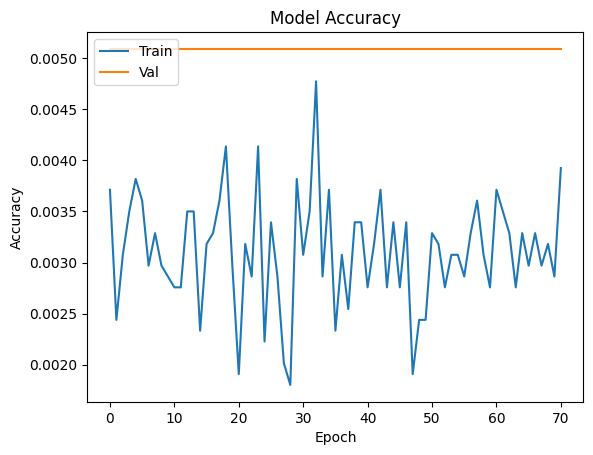

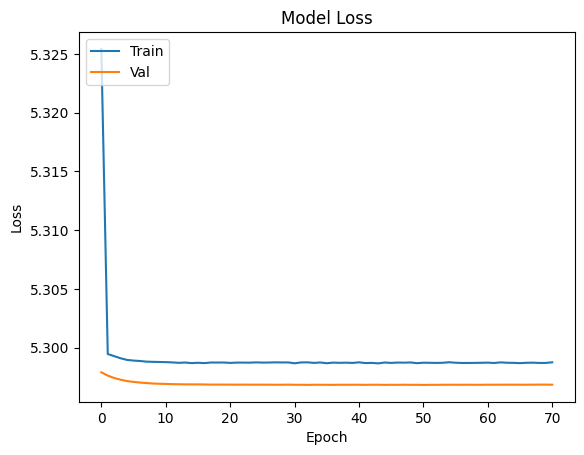

/home/joe/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 9s 124ms/step - loss: 5.2969 - accuracy: 0.0051


[5.296916961669922, 0.005089058540761471]

In [4]:
early_stopping = EarlyStopping(patience=20, restore_best_weights=True, min_delta=0, monitor='val_accuracy')
num_epochs = 200
leanring_rate = 0.0001

vgg16Model = VGG16(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(vgg16Model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vgg16Model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=leanring_rate), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=num_epochs, validation_data=val_generator ,callbacks=[early_stopping])
plot_accuracy_loss(history)

model.save('../models/vgg16_EARLY.h5')
model = tf.keras.models.load_model('../models/vgg16_EARLY.h5')
model.evaluate(test_generator)

Epoch 1/200
590/590 [==============================] - 111s 152ms/step - loss: 5.2528 - accuracy: 0.0064 - val_loss: 5.2971 - val_accuracy: 0.0068
Epoch 2/200
590/590 [==============================] - 84s 143ms/step - loss: 5.0879 - accuracy: 0.0113 - val_loss: 7.9021 - val_accuracy: 0.0119
Epoch 3/200
590/590 [==============================] - 84s 143ms/step - loss: 4.8970 - accuracy: 0.0191 - val_loss: 4.8192 - val_accuracy: 0.0229
Epoch 4/200
590/590 [==============================] - 85s 144ms/step - loss: 4.7790 - accuracy: 0.0209 - val_loss: 5.0784 - val_accuracy: 0.0204
Epoch 5/200
590/590 [==============================] - 85s 144ms/step - loss: 4.5856 - accuracy: 0.0366 - val_loss: 4.5217 - val_accuracy: 0.0416
Epoch 6/200
590/590 [==============================] - 85s 144ms/step - loss: 4.3765 - accuracy: 0.0546 - val_loss: 4.5072 - val_accuracy: 0.0568
Epoch 7/200
590/590 [==============================] - 86s 145ms/step - loss: 4.1957 - accuracy: 0.0783 - val_loss: 4.1737 

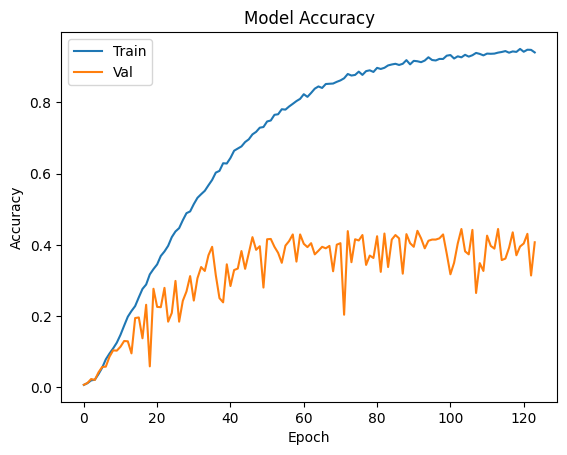

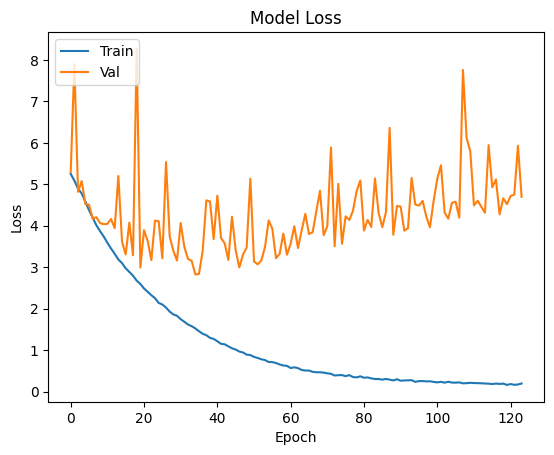

OSError: No file or directory found at model_EARLY.h5

In [5]:
early_stopping = EarlyStopping(patience=20, restore_best_weights=True, min_delta=0, monitor='val_accuracy')
num_epochs = 200
learning_rate = 0.0001
# Define the model
resnetModel = ResNet50(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(resnetModel.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=resnetModel.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(train_generator, epochs=num_epochs, validation_data=val_generator,callbacks=[early_stopping])
plot_accuracy_loss(history)

model.save('../models/ResNet50_EARLY.h5')
model = tf.keras.models.load_model('../models/ResNet50_EARLY.h5')
model.evaluate(test_generator)

In [7]:
model = tf.keras.models.load_model('../models/ResNet50_EARLY.h5')
model.evaluate(test_generator)

74/74 [==============================] - 10s 125ms/step - loss: 4.3914 - accuracy: 0.4258


[4.391399383544922, 0.42578455805778503]

Epoch 1/200
590/590 [==============================] - 85s 141ms/step - loss: 5.3601 - accuracy: 0.0034 - val_loss: 5.2979 - val_accuracy: 0.0051
Epoch 2/200
590/590 [==============================] - 82s 138ms/step - loss: 5.2995 - accuracy: 0.0032 - val_loss: 5.2976 - val_accuracy: 0.0051
Epoch 3/200
590/590 [==============================] - 81s 137ms/step - loss: 5.2993 - accuracy: 0.0033 - val_loss: 5.2974 - val_accuracy: 0.0051
Epoch 4/200
590/590 [==============================] - 80s 135ms/step - loss: 5.2991 - accuracy: 0.0040 - val_loss: 5.2973 - val_accuracy: 0.0051
Epoch 5/200
590/590 [==============================] - 79s 134ms/step - loss: 5.2990 - accuracy: 0.0025 - val_loss: 5.2972 - val_accuracy: 0.0051
Epoch 6/200
590/590 [==============================] - 79s 135ms/step - loss: 5.2990 - accuracy: 0.0034 - val_loss: 5.2971 - val_accuracy: 0.0051
Epoch 7/200
590/590 [==============================] - 80s 135ms/step - loss: 5.2989 - accuracy: 0.0037 - val_loss: 5.2970 -

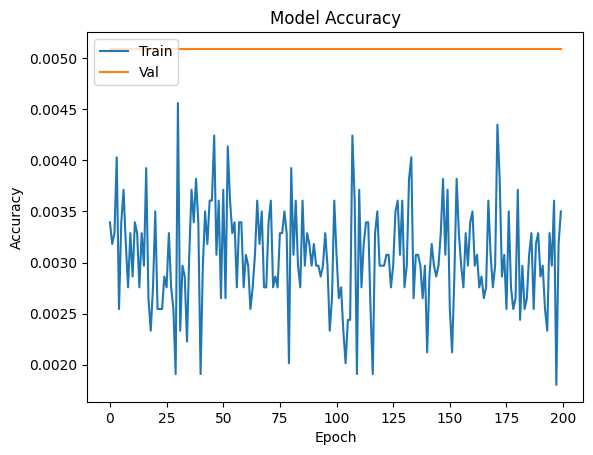

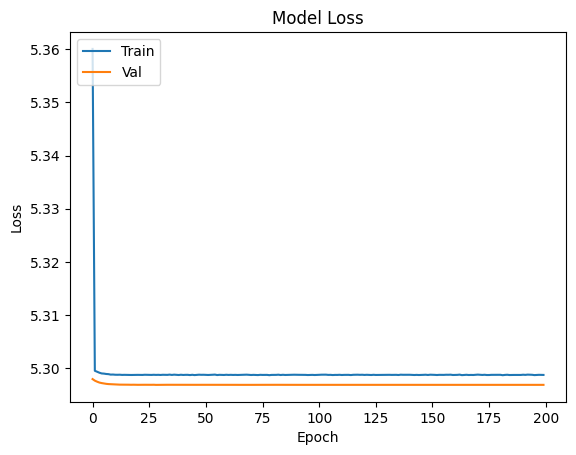

/home/joe/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 10s 128ms/step - loss: 5.2969 - accuracy: 0.0051


[5.296906471252441, 0.005089058540761471]

In [8]:
num_epochs = 200
leanring_rate = 0.0001

vgg16Model = VGG16(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(vgg16Model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vgg16Model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=leanring_rate), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=num_epochs, validation_data=val_generator)
plot_accuracy_loss(history)

model.save('../models/vgg16.h5')
model = tf.keras.models.load_model('../models/vgg16.h5')
model.evaluate(test_generator)

Epoch 1/200
590/590 [==============================] - 107s 152ms/step - loss: 5.2890 - accuracy: 0.0080 - val_loss: 5.2833 - val_accuracy: 0.0068
Epoch 2/200
590/590 [==============================] - 90s 152ms/step - loss: 5.1059 - accuracy: 0.0095 - val_loss: 5.1606 - val_accuracy: 0.0076
Epoch 3/200
590/590 [==============================] - 89s 151ms/step - loss: 4.9671 - accuracy: 0.0150 - val_loss: 7.4052 - val_accuracy: 0.0204
Epoch 4/200
590/590 [==============================] - 89s 150ms/step - loss: 4.8052 - accuracy: 0.0209 - val_loss: 4.7035 - val_accuracy: 0.0297
Epoch 5/200
590/590 [==============================] - 90s 152ms/step - loss: 4.6509 - accuracy: 0.0309 - val_loss: 4.8723 - val_accuracy: 0.0339
Epoch 6/200
590/590 [==============================] - 90s 152ms/step - loss: 4.5191 - accuracy: 0.0429 - val_loss: 4.4527 - val_accuracy: 0.0509
Epoch 7/200
590/590 [==============================] - 90s 152ms/step - loss: 4.3690 - accuracy: 0.0524 - val_loss: 4.5594 

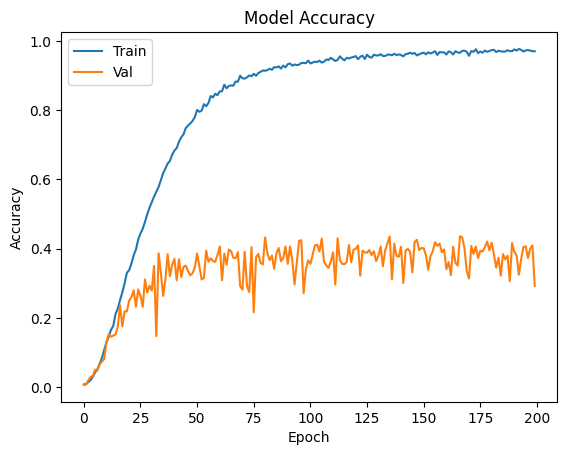

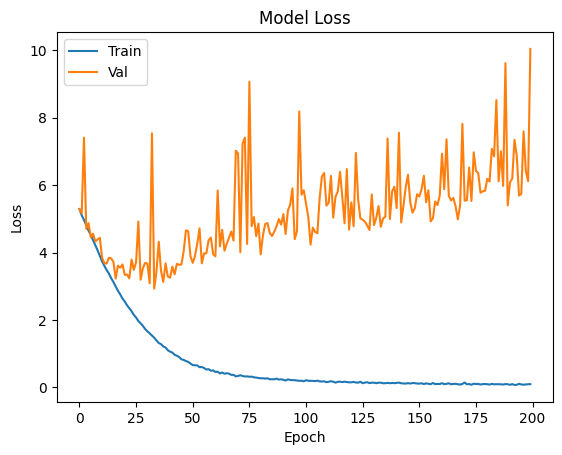

74/74 [==============================] - 9s 120ms/step - loss: 10.9781 - accuracy: 0.2841


[10.97813606262207, 0.28413909673690796]

In [9]:
num_epochs = 200
learning_rate = 0.0001
# Define the model
resnetModel = ResNet50(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(resnetModel.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=resnetModel.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(train_generator, epochs=num_epochs, validation_data=val_generator)
plot_accuracy_loss(history)

model.save('../models/ResNet50.h5')
model = tf.keras.models.load_model('../models/ResNet50.h5')
model.evaluate(test_generator)

#Inception with 229*299 images

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5], # Mimics ColorJitter's brightness adjustment
    channel_shift_range=0.2, # Partially mimics ColorJitter's hue adjustment
    fill_mode='nearest'
)

# Load the dataset and create generators
train_generator = train_datagen.flow_from_dataframe(
    directory=os.path.join(PATH, "images"),
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    dataframe=train_df,
    x_col="filepath",
    y_col="category",
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5], # Mimics ColorJitter's brightness adjustment
    channel_shift_range=0.2, # Partially mimics ColorJitter's hue adjustment
    fill_mode='nearest'
)

test_generator = test_datagen.flow_from_dataframe(
    directory=os.path.join(PATH, "images"),
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    dataframe=test_df,
    x_col="filepath",
    y_col="category",
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5], # Mimics ColorJitter's brightness adjustment
    channel_shift_range=0.2, # Partially mimics ColorJitter's hue adjustment
    fill_mode='nearest'
)

val_generator = val_datagen.flow_from_dataframe(
    directory=os.path.join(PATH, "images"),
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    dataframe=val_df,
    x_col="filepath",
    y_col="category",
)

Found 9430 validated image filenames belonging to 200 classes.
Found 1179 validated image filenames belonging to 200 classes.
Found 1179 validated image filenames belonging to 200 classes.


2023-12-19 08:18:42.697761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 08:18:42.715733: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 08:18:42.715804: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 08:18:42.717998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 08:18:42.718044: I external/local_xla/xla/stream_executor

Epoch 1/200


2023-12-19 08:18:53.221765: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-19 08:18:56.591605: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6cb58cde20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 08:18:56.591649: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-12-19 08:18:56.595927: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702991936.660624   28090 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


590/590 [==============================] - 172s 246ms/step - loss: 5.3140 - accuracy: 0.0024 - val_loss: 5.2980 - val_accuracy: 0.0051
Epoch 2/200
590/590 [==============================] - 138s 234ms/step - loss: 5.2995 - accuracy: 0.0018 - val_loss: 5.2976 - val_accuracy: 0.0051
Epoch 3/200
590/590 [==============================] - 135s 229ms/step - loss: 5.3000 - accuracy: 0.0032 - val_loss: 620.7712 - val_accuracy: 0.0051
Epoch 4/200
590/590 [==============================] - 134s 227ms/step - loss: 5.3028 - accuracy: 0.0024 - val_loss: 5.2973 - val_accuracy: 0.0051
Epoch 5/200
590/590 [==============================] - 135s 229ms/step - loss: 5.2991 - accuracy: 0.0037 - val_loss: 5.2972 - val_accuracy: 0.0034
Epoch 6/200
590/590 [==============================] - 133s 226ms/step - loss: 5.2989 - accuracy: 0.0036 - val_loss: 5.2971 - val_accuracy: 0.0051
Epoch 7/200
590/590 [==============================] - 134s 227ms/step - loss: 5.3031 - accuracy: 0.0037 - val_loss: 8.8097 - va

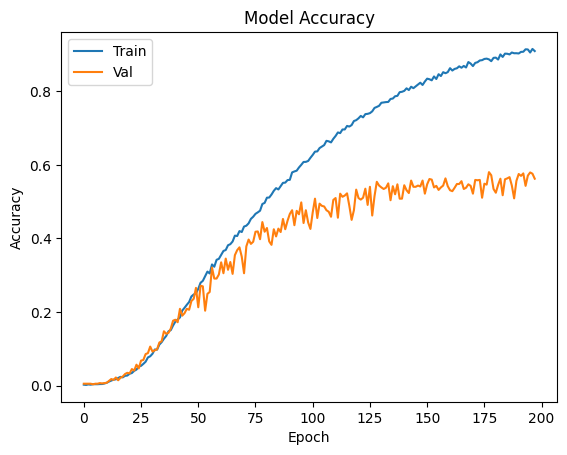

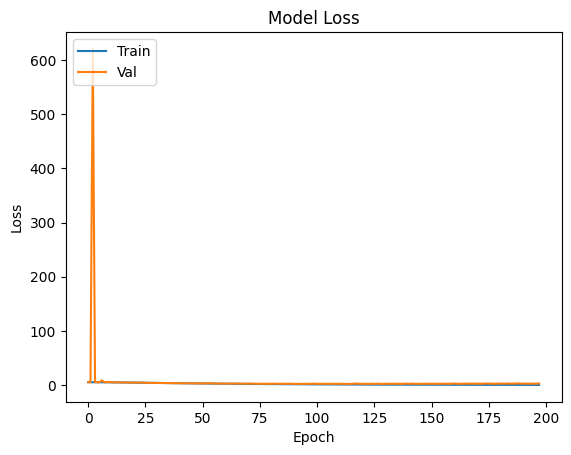

/home/joe/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 15s 194ms/step - loss: 2.2375 - accuracy: 0.5589


[2.23750638961792, 0.558948278427124]

In [4]:

early_stopping = EarlyStopping(patience=20, restore_best_weights=True, min_delta=0, monitor='val_accuracy')
num_epochs = 200
learning_rate = 0.0001
# Define the model
inceptionModel = InceptionV3(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(inceptionModel.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inceptionModel.input, outputs=predictions)
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(train_generator, epochs=num_epochs,validation_data=val_generator, callbacks=[early_stopping])
plot_accuracy_loss(history)
model.save('../models/InceptionV3_EARLY.h5')

model = tf.keras.models.load_model('../models/InceptionV3_EARLY.h5')
model.evaluate(test_generator)

2023-12-20 00:38:04.323736: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 00:38:04.463449: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 00:38:04.463511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 00:38:04.466286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 00:38:04.466334: I external/local_xla/xla/stream_executor

Epoch 1/200


2023-12-20 00:38:16.298933: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-20 00:38:19.859804: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe2be7d7180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 00:38:19.859833: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-12-20 00:38:19.869724: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703050699.948867     512 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


590/590 [==============================] - 172s 245ms/step - loss: 5.3105 - accuracy: 0.0038 - val_loss: 5.2979 - val_accuracy: 0.0051
Epoch 2/200
590/590 [==============================] - 135s 229ms/step - loss: 5.3019 - accuracy: 0.0039 - val_loss: 5.2977 - val_accuracy: 0.0051
Epoch 3/200
590/590 [==============================] - 134s 226ms/step - loss: 5.3013 - accuracy: 0.0036 - val_loss: 5.2977 - val_accuracy: 0.0051
Epoch 4/200
590/590 [==============================] - 135s 229ms/step - loss: 5.3011 - accuracy: 0.0040 - val_loss: 5.2979 - val_accuracy: 0.0051
Epoch 5/200
590/590 [==============================] - 133s 225ms/step - loss: 5.3009 - accuracy: 0.0052 - val_loss: 6.4183 - val_accuracy: 0.0059
Epoch 6/200
590/590 [==============================] - 133s 225ms/step - loss: 5.2975 - accuracy: 0.0036 - val_loss: 5.2972 - val_accuracy: 0.0051
Epoch 7/200
590/590 [==============================] - 134s 227ms/step - loss: 5.2991 - accuracy: 0.0038 - val_loss: 5.2973 - val_

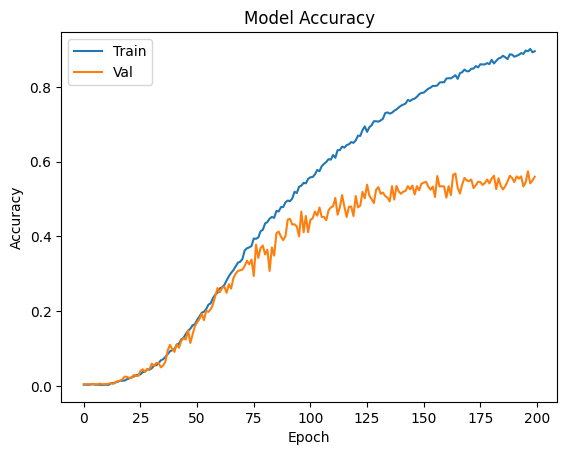

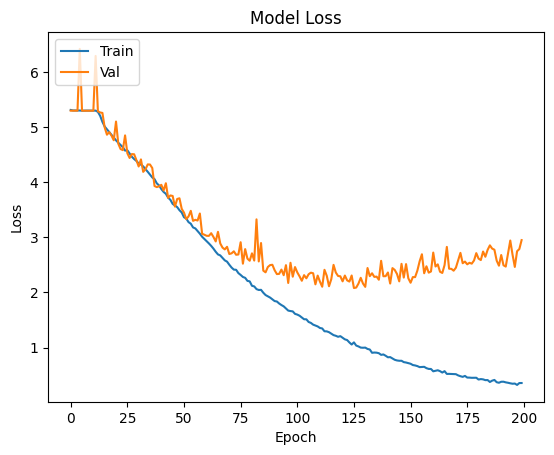

/home/joe/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 15s 194ms/step - loss: 2.4700 - accuracy: 0.5496


[2.4699976444244385, 0.5496183037757874]

In [3]:

num_epochs = 200
learning_rate = 0.0001
# Define the model
inceptionModel = InceptionV3(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(inceptionModel.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inceptionModel.input, outputs=predictions)
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(train_generator, epochs=num_epochs,validation_data=val_generator)
plot_accuracy_loss(history)
model.save('../models/InceptionV3.h5')

model = tf.keras.models.load_model('../models/InceptionV3.h5')
model.evaluate(test_generator)